In [ ]:
# ! pip install autogluon

In [ ]:
# ! pip install biovec

In [1]:
! pip install protein-bert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 14.9 MB/s 
     |████████████████████████████████| 103 kB 30.2 MB/s 
  Created wheel for pyfaidx: filename=pyfaidx-0.7.1-py3-none-any.whl size=27748 sha256=af2d7189917dc149e8bddc1522d9919b208462d4857d850bb09a7bb498362809
  Stored in directory: /root/.cache/pip/wheels/0e/6c/f4/2560f2678a35d8b1997bb693336743308ef32b78bc9ce9aaf4
Successfully built pyfaidx


In [2]:
%cd drive/MyDrive/altegrad

/content/drive/MyDrive/altegrad


In [3]:
import csv
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Read sequences
sequences = list()
with open('sequences.txt', 'r') as f:
    for line in f:
        sequences.append(line[:-1])

# Split data into training and test sets
sequences_train = list()
sequences_test = list()
proteins_test = list()
y_train = list()
with open('graph_labels.txt', 'r') as f:
    for i,line in enumerate(f):
        t = line.split(',')
        if len(t[1][:-1]) == 0:
            proteins_test.append(t[0])
            sequences_test.append(sequences[i])
        else:
            sequences_train.append(sequences[i])
            y_train.append(int(t[1][:-1]))

In [4]:
train_set = pd.DataFrame()
train_set['seq'] = sequences_train
train_set['label'] = y_train
test_set = pd.DataFrame()
test_set['seq'] = sequences_test

In [5]:
train_set.head()

,seq,label
0,RTDCYGNVNRIDTTGASCKTAKPEGLSYCGVSASKKIAERDLQAMD...,8
1,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLAAAKAAL...,4
2,SPLLETCVPDRGREYRGRLAVTTHGSRCLAWSSEQAKALSKDQDFN...,8
3,IVGGYECRKNSASYQASLQSGYHFCGGSLISSTWVVSAAHCYKSRI...,8
4,QDLARIEQFLDALWLEKNLAENTLNAYRRDLSMMVEWLHHRGLTLA...,15


In [6]:
import os

import pandas as pd
from IPython.display import display

from tensorflow import keras

from sklearn.model_selection import train_test_split

from proteinbert import OutputType, OutputSpec, FinetuningModelGenerator, load_pretrained_model, finetune, evaluate_by_len
from proteinbert.conv_and_global_attention_model import get_model_with_hidden_layers_as_outputs
from proteinbert.finetuning import encode_seq_Y
# A local (non-global) bianry output
OUTPUT_TYPE = OutputType(False, 'categorical')
UNIQUE_LABELS = np.unique(train_set['label'])
OUTPUT_SPEC = OutputSpec(OUTPUT_TYPE, UNIQUE_LABELS)



### finetune

In [10]:
# Loading the dataset

# train_set_file_path = os.path.join(BENCHMARKS_DIR, '%s.train.csv' % BENCHMARK_NAME)
# train_set = pd.read_csv(train_set_file_path).dropna().drop_duplicates()
train_set, valid_set = train_test_split(train_set, stratify = train_set['label'], test_size = 0.1, random_state = 0)


In [11]:
# test_set_file_path = os.path.join(BENCHMARKS_DIR, '%s.test.csv' % BENCHMARK_NAME)
# test_set = pd.read_csv(test_set_file_path).dropna().drop_duplicates()

print(f'{len(train_set)} training set records, {len(valid_set)} validation set records, {len(test_set)} test set records.')


# Loading the pre-trained model and fine-tuning it on the loaded dataset

pretrained_model_generator, input_encoder = load_pretrained_model('./trained_models','epoch_92400_sample_23500000.pkl')

# get_model_with_hidden_layers_as_outputs gives the model output access to the hidden layers (on top of the output)
model_generator = FinetuningModelGenerator(pretrained_model_generator, OUTPUT_SPEC, pretraining_model_manipulation_function = \
        get_model_with_hidden_layers_as_outputs, dropout_rate = 0.5)

training_callbacks = [
    keras.callbacks.ReduceLROnPlateau(patience = 1, factor = 0.25, min_lr = 1e-05, verbose = 1),
    keras.callbacks.EarlyStopping(patience = 2, restore_best_weights = True),
]

finetune(model_generator, input_encoder, OUTPUT_SPEC, train_set['seq'], train_set['label'], valid_set['seq'], valid_set['label'], \
        seq_len = 512, batch_size = 32, max_epochs_per_stage = 40, lr = 1e-04, begin_with_frozen_pretrained_layers = True, \
        lr_with_frozen_pretrained_layers = 1e-02, n_final_epochs = 1, final_seq_len = 1024, final_lr = 1e-05, callbacks = training_callbacks)


# Evaluating the performance on the test-set

# results, confusion_matrix = evaluate_by_len(model_generator, input_encoder, OUTPUT_SPEC, test_set['seq'], test_set['label'], \
        # start_seq_len = 512, start_batch_size = 32)

# print('Test-set performance:')
# display(results)

# print('Confusion matrix:')
# display(confusion_matrix)

4399 training set records, 489 validation set records, 1223 test set records.
[2022_12_13-07:47:19] Training set: Filtered out 344 of 4399 (7.8%) records of lengths exceeding 510.
[2022_12_13-07:47:19] Validation set: Filtered out 32 of 489 (6.5%) records of lengths exceeding 510.
[2022_12_13-07:47:19] Training with frozen pretrained layers...


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/40
127/127 [==============================] - ETA: 0s - loss: 1.4894

127/127 [==============================] - 27s 92ms/step - loss: 1.4894 - val_loss: 1.1810 - lr: 0.0100
Epoch 2/40
126/127 [============================>.] - ETA: 0s - loss: 0.9540

127/127 [==============================] - 9s 69ms/step - loss: 0.9519 - val_loss: 1.1499 - lr: 0.0100
Epoch 3/40
126/127 [============================>.] - ETA: 0s - loss: 0.7393


Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
127/127 [==============================] - 9s 69ms/step - loss: 0.7402 - val_loss: 1.1719 - lr: 0.0100
Epoch 4/40
127/127 [==============================] - ETA: 0s - loss: 0.5148

127/127 [==============================] - 9s 71ms/step - loss: 0.5148 - val_loss: 1.0262 - lr: 0.0025
Epoch 5/40
127/127 [==============================] - ETA: 0s - loss: 0.4761

127/127 [==============================] - 9s 71ms/step - loss: 0.4761 - val_loss: 1.0013 - lr: 0.0025
Epoch 6/40
127/127 [==============================] - ETA: 0s - loss: 0.4358


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.
127/127 [==============================] - 9s 71ms/step - loss: 0.4358 - val_loss: 1.0124 - lr: 0.0025
Epoch 7/40
126/127 [============================>.] - ETA: 0s - loss: 0.3951


Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
127/127 [==============================] - 9s 71ms/step - loss: 0.3950 - val_loss: 1.0013 - lr: 6.2500e-04
[2022_12_13-07:48:46] Training the entire fine-tuned model...
[2022_12_13-07:48:57] Incompatible number of optimizer weights - will not initialize them.
Epoch 1/40
127/127 [==============================] - ETA: 0s - loss: 0.3798

127/127 [==============================] - 33s 198ms/step - loss: 0.3798 - val_loss: 1.0231 - lr: 1.0000e-04
Epoch 2/40
127/127 [==============================] - ETA: 0s - loss: 0.2872


Epoch 2: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
127/127 [==============================] - 22s 177ms/step - loss: 0.2872 - val_loss: 1.1045 - lr: 1.0000e-04
Epoch 3/40
127/127 [==============================] - ETA: 0s - loss: 0.2195


Epoch 3: ReduceLROnPlateau reducing learning rate to 1e-05.
127/127 [==============================] - 23s 179ms/step - loss: 0.2195 - val_loss: 1.0749 - lr: 2.5000e-05
[2022_12_13-07:50:16] Training on final epochs of sequence length 1024...
[2022_12_13-07:50:16] Training set: Filtered out 0 of 4399 (0.0%) records of lengths exceeding 1022.
[2022_12_13-07:50:28] Validation set: Filtered out 0 of 489 (0.0%) records of lengths exceeding 1022.
275/275 [==============================] - ETA: 0s - loss: 0.4825

275/275 [==============================] - 59s 189ms/step - loss: 0.4825 - val_loss: 1.0265 - lr: 1.0000e-05


In [21]:
type(pretrained_model_generator)

proteinbert.model_generation.PretrainingModelGenerator

In [22]:
type(model_generator)

proteinbert.model_generation.FinetuningModelGenerator

In [19]:
from proteinbert.conv_and_global_attention_model import get_model_with_hidden_layers_as_outputs

In [23]:
model.outputs[0].shape

TensorShape([None, 18])

### predict

In [7]:
import pickle

In [8]:
# with open('finetuned_model_weights.pkl', 'wb') as f:
#   pickle.dump(model_generator.model_weights, f)

In [9]:

# unpickling the weights
with open('./trained_models/finetuned_model_weights.pkl', 'rb') as f:
    saved_model_weights = pickle.load(f)

saved_pretrained_model_generator, saved_input_encoder = load_pretrained_model(local_model_dump_dir='./trained_models/', 
                                        local_model_dump_file_name= "epoch_92400_sample_23500000.pkl",)
saved_model_generator = FinetuningModelGenerator(saved_pretrained_model_generator, OUTPUT_SPEC, 
                                           pretraining_model_manipulation_function = get_model_with_hidden_layers_as_outputs, 
                                           dropout_rate = 0.5,
                                            model_weights = saved_model_weights,)

In [10]:
model = saved_model_generator.create_model(seq_len=1024)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [11]:
X = saved_input_encoder.encode_X(test_set['seq'], 1024)

In [12]:
y_pred_proba = model.predict(X, batch_size=32)

39/39 [==============================] - 15s 103ms/step


### embedding

In [20]:
model = get_model_with_hidden_layers_as_outputs(model_generator.create_model(seq_len=1024))

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


ValueError: ignored

In [17]:
type(model)

keras.engine.functional.Functional

In [26]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input-annotations (InputLayer)  [(None, 8943)]      0           []                               
                                                                                                  
 dense-global-input (Dense)     (None, 512)          4579328     ['input-annotations[0][0]']      
                                                                                                  
 input-seq (InputLayer)         [(None, 1024)]       0           []                               
                                                                                                  
 embedding-seq-input (Embedding  (None, 1024, 128)   3328        ['input-seq[0][0]']              
 )                                                                                          

In [18]:
model(test_set['seq'])

ValueError: ignored

### legacy

In [6]:
# import biovec
# # load trained model from file
# pv = biovec.models.load_protvec('./trained_models/swissprot-reviewed-protvec.model')
# # The n-gram "QAT" should be trained in advance
# pv["QAT"]
# # convert whole amino acid sequence into three vectors
# np.concatenate(pv.to_vecs("ATATQSQSMTEEL")).shape
# def protein_vectorizer(pv, sequences):
#   vecs = []
#   for seq in sequences:
#     vecs.append(np.concatenate(pv.to_vecs(seq)))
#   return np.array(vecs)
# X_train = protein_vectorizer(pv, sequences_train)
# X_test = protein_vectorizer(pv, sequences_test)

In [ ]:
# vec = TfidfVectorizer(analyzer='char', ngram_range=(1, 3))
# X_train = vec.fit_transform(sequences_train)
# X_test = vec.transform(sequences_test)

### dimension reduction

In [20]:
X_train.shape, X_test.shape

((4888, 300), (1223, 300))

In [21]:
import scipy.sparse as sp
# X = np.vstack((X_train.toarray(), X_test.toarray()))
X = np.vstack((X_train, X_test))
X.shape

(6111, 300)

In [22]:
X_sparse = sp.csr_matrix(X)
from sklearn.decomposition import PCA, TruncatedSVD
# pca = PCA()
# pca.fit(X)
svd = TruncatedSVD(n_components=100)
svd.fit(X)

TruncatedSVD(n_components=100)

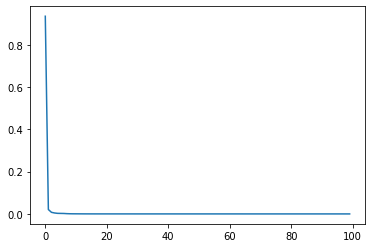

In [23]:
import matplotlib.pyplot as plt
plt.plot(svd.explained_variance_ratio_)

In [24]:
X_new = svd.transform(X)

In [25]:
X_train_new,X_test_new = np.split(X_new,[X_train.shape[0]])

In [26]:
X_train_new.shape, X_test_new.shape

((4888, 100), (1223, 100))

In [27]:
import pandas as pd
df_train = pd.DataFrame(X_train_new)

In [28]:
df_test = pd.DataFrame(X_test_new)

In [29]:
df_train.columns = range(df_train.shape[1])

In [30]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,109.356285,-3.833646,1.947854,-3.292883,-3.311949,-3.826015,2.099040,0.767798,2.387406,1.107896,...,0.157269,0.009353,1.469527,-0.574874,-0.819050,-1.247810,-0.380742,0.439964,-0.922429,0.744784
1,95.190033,3.552568,-1.110898,1.178499,-3.149377,2.008976,0.319801,2.897786,1.612790,0.802957,...,-1.144361,0.307865,-0.397985,-0.630404,-0.072420,0.736623,0.101293,0.568477,0.358596,0.272354
2,91.898407,4.611051,-9.922841,-3.976764,2.506440,-3.109526,0.744523,-2.573282,-0.899285,-0.975165,...,0.857180,0.173358,0.051491,0.699263,0.703107,0.195032,-1.067464,0.141507,-0.181663,-0.193661
3,130.014771,-0.600953,10.946375,-12.460989,7.522354,-5.938076,-4.659488,4.595666,-1.887816,1.056845,...,1.295376,1.773097,-0.730816,0.430094,1.107836,-1.247855,0.662269,-0.096713,-0.239922,0.811489
4,159.222198,15.575222,-13.679247,8.938797,5.937868,9.212132,-7.184511,-0.538958,1.536754,4.107922,...,-0.326325,-0.220549,1.570862,-0.138844,-0.994112,0.336825,-0.717504,-0.661034,1.895639,-2.432443


In [ ]:
np.unique(y_train,return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 array([440,  50, 939,  60, 112, 625, 202,  74, 998,  57,  43, 305,  44,
         59, 548, 226,  60,  46]))

In [31]:
df_train['class'] = y_train

In [32]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,class
0,109.356285,-3.833646,1.947854,-3.292883,-3.311949,-3.826015,2.099040,0.767798,2.387406,1.107896,...,0.009353,1.469527,-0.574874,-0.819050,-1.247810,-0.380742,0.439964,-0.922429,0.744784,8
1,95.190033,3.552568,-1.110898,1.178499,-3.149377,2.008976,0.319801,2.897786,1.612790,0.802957,...,0.307865,-0.397985,-0.630404,-0.072420,0.736623,0.101293,0.568477,0.358596,0.272354,4
2,91.898407,4.611051,-9.922841,-3.976764,2.506440,-3.109526,0.744523,-2.573282,-0.899285,-0.975165,...,0.173358,0.051491,0.699263,0.703107,0.195032,-1.067464,0.141507,-0.181663,-0.193661,8
3,130.014771,-0.600953,10.946375,-12.460989,7.522354,-5.938076,-4.659488,4.595666,-1.887816,1.056845,...,1.773097,-0.730816,0.430094,1.107836,-1.247855,0.662269,-0.096713,-0.239922,0.811489,8
4,159.222198,15.575222,-13.679247,8.938797,5.937868,9.212132,-7.184511,-0.538958,1.536754,4.107922,...,-0.220549,1.570862,-0.138844,-0.994112,0.336825,-0.717504,-0.661034,1.895639,-2.432443,15


### automl

In [33]:
from autogluon.tabular import TabularPredictor
predictor = TabularPredictor(label='class', eval_metric='log_loss').fit(df_train)

No path specified. Models will be saved in: "AutogluonModels/ag-20221213_063533/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20221213_063533/"
AutoGluon Version:  0.6.1
Python Version:     3.8.16
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Aug 26 08:44:51 UTC 2022
Train Data Rows:    4888
Train Data Columns: 100
Label Column: class
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	First 10 (of 18) unique label values:  [8, 4, 15, 2, 5, 14, 6, 0, 7, 11]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Train Data Class Count: 18
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:          

In [34]:
predictor.leaderboard()

                  model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2  -1.559590       0.232404  591.461384                0.001745           1.947704            2       True         14
1              CatBoost  -1.621898       0.014483  504.905191                0.014483         504.905191            1       True          8
2               XGBoost  -1.686165       0.048245   72.859671                0.048245          72.859671            1       True         11
3            LightGBMXT  -1.754040       0.039574   64.923428                0.039574          64.923428            1       True          4
4              LightGBM  -1.763998       0.033591   91.223648                0.033591          91.223648            1       True          5
5      RandomForestGini  -1.789424       0.173489   12.642138                0.173489          12.642138            1       True          6
6      RandomForestE

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-1.559590,0.232404,591.461384,0.001745,1.947704,2,True,14
1,CatBoost,-1.621898,0.014483,504.905191,0.014483,504.905191,1,True,8
2,XGBoost,-1.686165,0.048245,72.859671,0.048245,72.859671,1,True,11
3,LightGBMXT,-1.754040,0.039574,64.923428,0.039574,64.923428,1,True,4
4,LightGBM,-1.763998,0.033591,91.223648,0.033591,91.223648,1,True,5
5,RandomForestGini,-1.789424,0.173489,12.642138,0.173489,12.642138,1,True,6
6,RandomForestEntr,-1.823082,0.133737,65.691098,0.133737,65.691098,1,True,7
7,LightGBMLarge,-1.834919,0.096019,249.975205,0.096019,249.975205,1,True,13
8,NeuralNetTorch,-1.886279,0.018213,5.928432,0.018213,5.928432,1,True,12
9,NeuralNetFastAI,-1.930751,0.042273,5.778196,0.042273,5.778196,1,True,3


In [35]:
predictor.refit_full(model='best', set_best_to_refit_full=True)

Fitting 1 L1 models ...
Fitting model: KNeighborsDist_FULL ...
	0.04s	 = Training   runtime
Fitting 1 L1 models ...
Fitting model: NeuralNetFastAI_FULL ...
	Stopping at the best epoch learned earlier - 3.
	1.07s	 = Training   runtime
Fitting 1 L1 models ...
Fitting model: CatBoost_FULL ...
	399.14s	 = Training   runtime
Fitting 1 L1 models ...
Fitting model: XGBoost_FULL ...
	25.03s	 = Training   runtime
Fitting 1 L1 models ...
Fitting model: NeuralNetTorch_FULL ...
	2.51s	 = Training   runtime
Fitting model: WeightedEnsemble_L2_FULL | Skipping fit via cloning parent ...
	1.95s	 = Training   runtime
Updated best model to "WeightedEnsemble_L2_FULL" (Previously "WeightedEnsemble_L2"). AutoGluon will default to using "WeightedEnsemble_L2_FULL" for predict() and predict_proba().


{'KNeighborsDist': 'KNeighborsDist_FULL',
 'NeuralNetFastAI': 'NeuralNetFastAI_FULL',
 'CatBoost': 'CatBoost_FULL',
 'XGBoost': 'XGBoost_FULL',
 'NeuralNetTorch': 'NeuralNetTorch_FULL',
 'WeightedEnsemble_L2': 'WeightedEnsemble_L2_FULL'}

In [36]:
predict_proba = predictor.predict_proba(df_test)

In [37]:
y_pred_proba = predict_proba.to_numpy()

### write

In [17]:
with open('proteinBert_finetuning_log_loss_refit_full.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = list()
    for i in range(18):
        lst.append('class'+str(i))
    lst.insert(0, "name")
    writer.writerow(lst)
    for i, protein in enumerate(proteins_test):
        lst = y_pred_proba[i,:].tolist()
        lst.insert(0, protein)
        writer.writerow(lst)